# Appendix A: 

ADS 599 Capstone: NLP + Machine Learning Techniques to Identifying Fake Job Postings

Team 2:
* Brianne Bell 
* Zachariah Freitas

## Data Importing and Pre-processing
* Step 1: Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Step 2: Clean, wrangle, and handle missing and duplicated data
* Step 3: Transform data appropriately using nlp techniques such as feature embedding construction

### Dataset Description
This dataset contains approximately 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. We will use this dataset to create classification models to determine which job descriptions are fraudulent.

Origin: Kaggle \
File Type: CSV \
File Size: 47.7 MB \
Modeling Problem: Classification \
Missing Values: Yes \
Duplicated Values: Yes \
Unbalanced Dataset: Yes 

## Data Analysis and Visualization
* Identify categorical, ordinal, and numerical variables within data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest
## Feature Descriptions
### Categorical Features:
* title: The title of the job ad entry. (text)
* location: Geographical location of the job ad. (categorical: e.g. US, NY, New York)
* department: Corporate department (categorical: e.g. sales).
* salary_range: Indicative salary range (categorical: e.g. $50,000-$60,000)
* company_profile: A brief company description. (text)
* description: The details description of the job ad. (text)
* requirements: Enlisted requirements for the job opening. (text)
* benefits: Enlisted offered benefits by the employer. (text)
* employment_type: Full-type, Part-time, Contract, etc. (categorical: e.g. Full-type)
* required_experience: Executive, Entry level, Intern, etc. (categorical: e.g. Executive)
* required_education: Doctorate, Master’s Degree, Bachelor, etc. (categorical: e.g. Bachelor)
* industry: Automotive, IT, Health care, Real estate, etc. (categorical: e.g. Automotive)
* function: Consulting, Engineering, Research, Sales etc. (categorical: e.g. Engineering)

### Numerical Features:
* job_id: Unique Job ID (numeric)
* telecommuting: True for telecommuting positions. (Binary: 1="True",0="False")
* has_company_logo: True if company logo is present. (Binary: 1="True",0="False") 
* has_questions: True if screening questions are present. (Binary: 1="True",0="False") 

### Target Feature:
* fraudulent: Target - Classification attribute. Is the job posting fraudulent? (Binary: 1="True",0="False") 

In [92]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import os
import re
import random
import time
import datetime
import missingno
from scipy.stats import chi2_contingency

import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec # to do the grid of plots
import matplotlib.ticker as mtick

%matplotlib inline

In [93]:
# Helper Functions

# Bar Plot
def target_distribution(data, target):
    '''
        This fuction displays the distribution of the specified numeric variable in the input data frame.
        
        params:
        data: input data frame.
        target: string specifying the name of target variable.
        
        Returns: None.
        
    '''
    data = data.copy()
    sns.countplot(data=data,x=target,palette=['black','gray']);
    tgt_cnt = data[target].value_counts()
    tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)
    plt.text(x=-0.2,y=tgt_cnt[0]/2,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)',backgroundcolor='white')
    plt.text(x=0.8,y=tgt_cnt[1]/2,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)',backgroundcolor='white')
    plt.title('Target Distribution')
    
    
def categorical_variables_vs_target(data, categorical_variables, target):
    categorical_variables = categorical_variables.copy()
    data = data.copy()
    categorical_variables = categorical_variables.copy()
    for i in categorical_variables:
        ct = pd.crosstab(columns=data[i],index=data[target])
        stat, p, dof, expected = chi2_contingency(ct) 
        print(f"\n{'-'*len(f'Chi-Square test between {i} & {target}')}")
        print(f'Chi-Square test between {i} & {target}')
        print(f"{'-'*len(f'Chi-Square test between {i} & {target}')}")
        print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}")
        print(f"\nP-VALUE: {p}")
        print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")

# Read Dataset and Display Info
Loading up the original data from Kaggle.

In [94]:
file_path = '../Data Folder/fake_job_postings.csv'
raw_df = pd.read_csv(file_path)
print('Raw Data Shape: ')
print(raw_df.shape)
print('\nColumns in the raw data:')
print(raw_df.columns)
print('\n')
print('\n\n',raw_df.info())

Raw Data Shape: 
(17880, 18)

Columns in the raw data:
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   be

# Display Columns

In [95]:
# example of data contents
raw_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


There are 18 columns, one of which is the outcome called fraudulent.
There are 17,880 entries, but there are null entries throughout. 

# Duplicates
Reviewing data for duplicated rows.

In [96]:
# Count the number of dubplicated rows.
n = len(raw_df)-len(raw_df.drop_duplicates())

print("No. of duplicated rows :", n)

No. of duplicated rows : 0


In [97]:
# check the cardinality for each column
n = pd.DataFrame(raw_df.nunique(axis=0), index=None, columns=["Cardinality"])

n.style.bar(subset=['Cardinality'], color='#d65f5f')

,Cardinality
job_id,17880
title,11231
location,3105
department,1337
salary_range,874
company_profile,1709
description,14801
requirements,11968
benefits,6205
telecommuting,2


There are no duplicated rows in the data.

job_id appears to have no value in this analysis and is an id associated with the posting, not controled by the poster.

In [98]:
# Let's check the number of duplicated rows in the dataset after removing the job_id column.
n = len(raw_df.loc[:, raw_df.columns!='job_id'])-len(raw_df.loc[:, raw_df.columns!='job_id'].drop_duplicates())

print("No. of duplicated rows :", n)

No. of duplicated rows : 281


# Deduplicating Data

In [99]:
dd_raw_df = raw_df.loc[:, raw_df.columns!='job_id'].drop_duplicates()

print("Undeduplicated Data Shape: ")
print(raw_df.fraudulent.value_counts())

print("\nDeduplicated Data Shape: ")
print(dd_raw_df.fraudulent.value_counts())

Undeduplicated Data Shape: 
0    17014
1      866
Name: fraudulent, dtype: int64

Deduplicated Data Shape: 
0    16743
1      856
Name: fraudulent, dtype: int64


Most of the duplicated rows are in the non-fraudulent group. 
I think we can safely drop duplicated rows and job_id from our dataset.

# Missing Data

In [100]:
# looking at what is null
print(dd_raw_df.isnull().sum().sort_values(ascending=False))
print('\nTotal number of null values: ', dd_raw_df.isnull().sum().sum())


salary_range           14772
department             11328
required_education      8009
benefits                7106
required_experience     6962
function                6363
industry                4837
employment_type         3428
company_profile         3282
requirements            2648
location                 341
description                1
title                      0
telecommuting              0
has_questions              0
has_company_logo           0
fraudulent                 0
dtype: int64

Total number of null values:  69077


<Axes: >

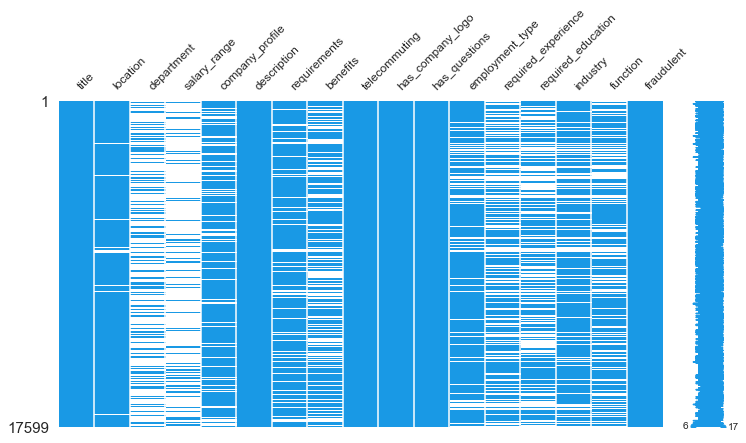

In [144]:
# checking missing data in our dataframe.
missingno.matrix(dd_raw_df,color=(0.1, 0.6, 0.9), figsize=(12,6), 
                 fontsize=12)

Columns with no missing data:
* job_id
* title
* telecommuting
* has_company_logo
* has_questions
* fraudulent

The description field is only missing one entry.

job_id appears to have no value and is an id associated with the posting, not controled by the poster.

The largest amount of missing entries is in salary_range followed by department. 

We note a total of 70,103 null values occuring across all features.

In [102]:
# looking at what is null when fraudulent is 1
print(dd_raw_df[dd_raw_df['fraudulent']==1].shape)
print(dd_raw_df[dd_raw_df['fraudulent']==1].isnull().sum().sort_values(ascending=False))
print('\nTotal number of null values: ', dd_raw_df[dd_raw_df['fraudulent']==1].isnull().sum().sum())

(856, 17)
salary_range           635
company_profile        580
department             524
required_education     444
required_experience    427
benefits               359
function               330
industry               270
employment_type        236
requirements           151
location                19
description              1
title                    0
telecommuting            0
has_questions            0
has_company_logo         0
fraudulent               0
dtype: int64

Total number of null values:  3976


<Axes: >

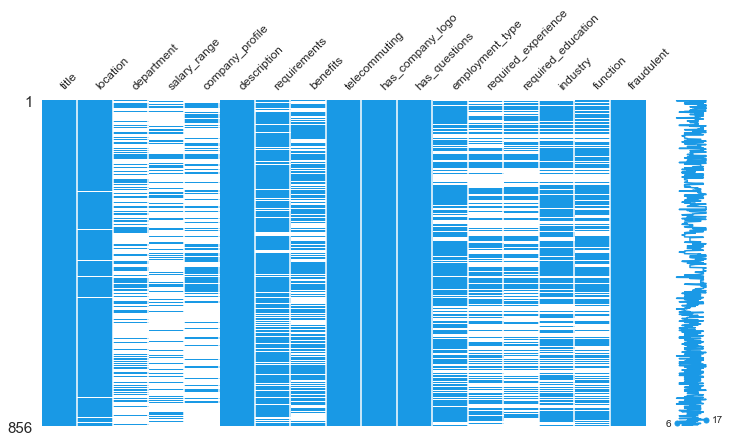

In [142]:
# checking missing data in our dataframe when fraudulent is 1
missingno.matrix(dd_raw_df[dd_raw_df['fraudulent']==1],
                 color=(0.1, 0.6, 0.9), figsize=(12,6), 
                 fontsize=12)

### Observations
From these statistics we observe that:

* Missing data is probably not an issue with this dataset.
* Missing data appears to be balanced between fraudulant and non-fraudulant job postings.

# Categorize Feature Types

In [104]:
# Categorized the variables into categorical, numeric, and target variables
categorical_variables = list(dd_raw_df.select_dtypes('object').columns)

numeric_variables = list(dd_raw_df.select_dtypes(['float64','int64']).columns)
numeric_variables.remove('fraudulent')

target = 'fraudulent'

print(f'Categorical Variables ({len(categorical_variables)}):\n{categorical_variables}' + 
      f'\n\nNumeric Variables ({len(numeric_variables)}):\n{numeric_variables}' + 
      f'\n\nTarget:\n{target}')

Categorical Variables (13):
['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

Numeric Variables (3):
['telecommuting', 'has_company_logo', 'has_questions']

Target:
fraudulent


# Target EDA

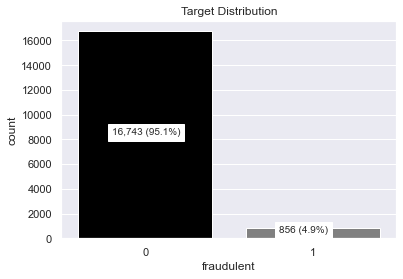

In [105]:
# Plot Target Variable fraudulent distribution.
target_distribution(data=dd_raw_df,
                       target=target)

# Categorical EDA
Due to high cardinality, we will omit some of the categorical features above.

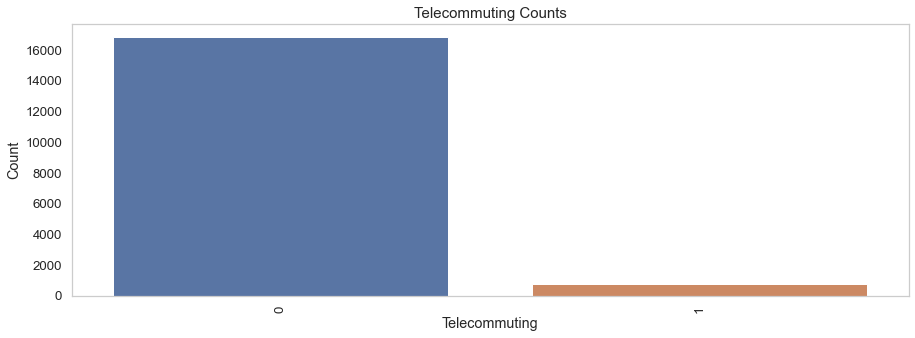

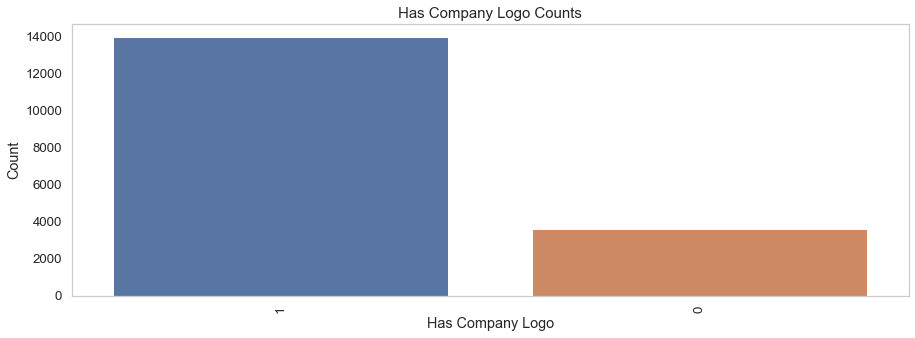

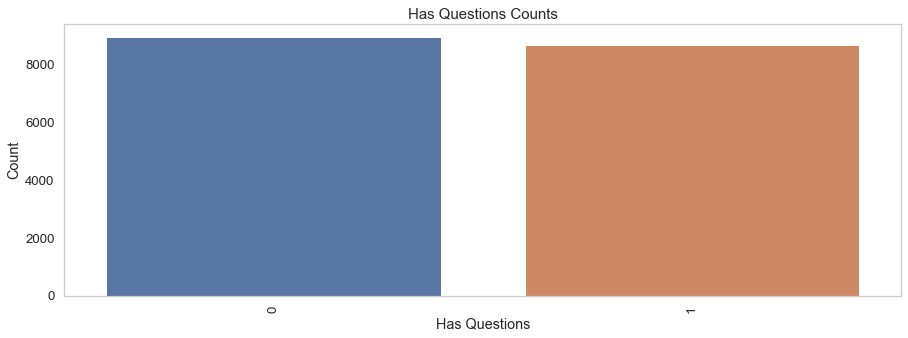

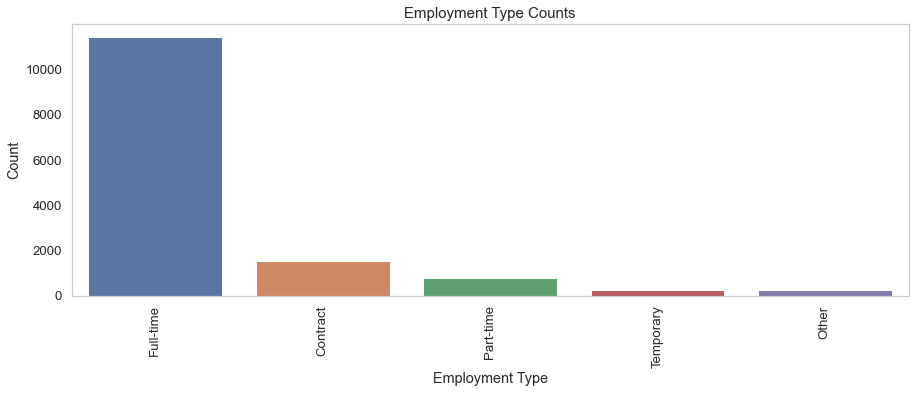

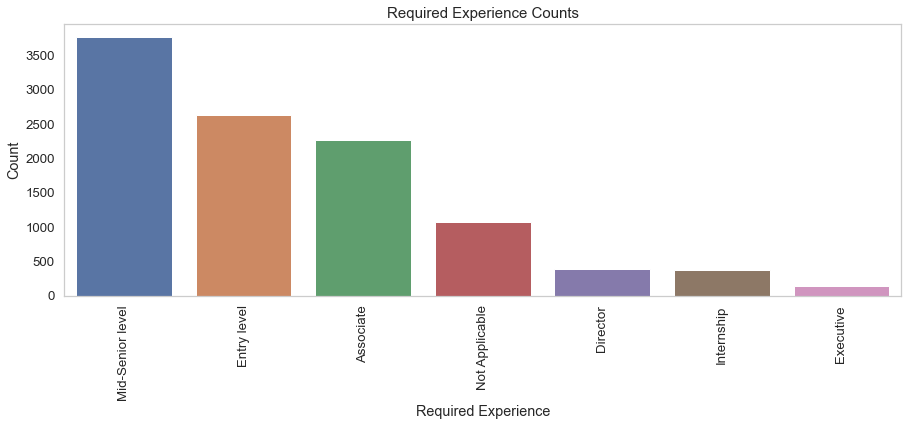

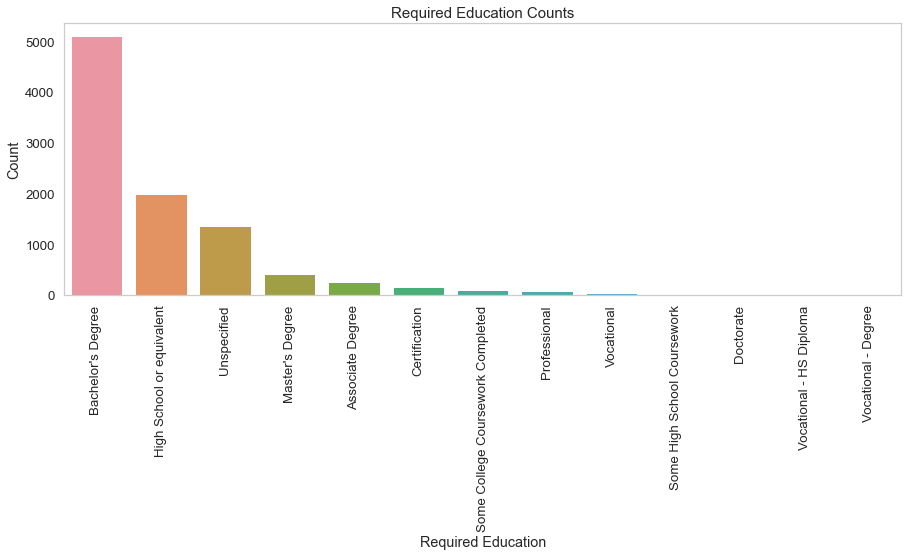

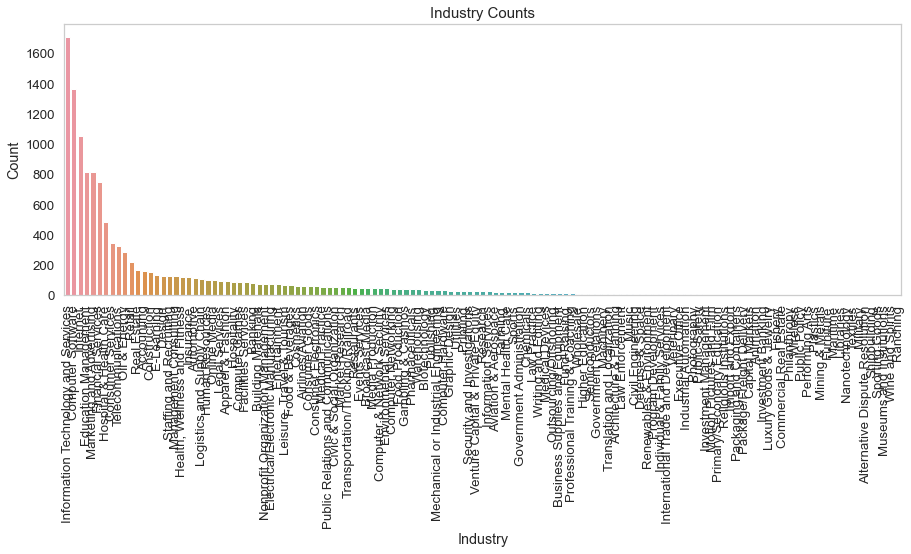

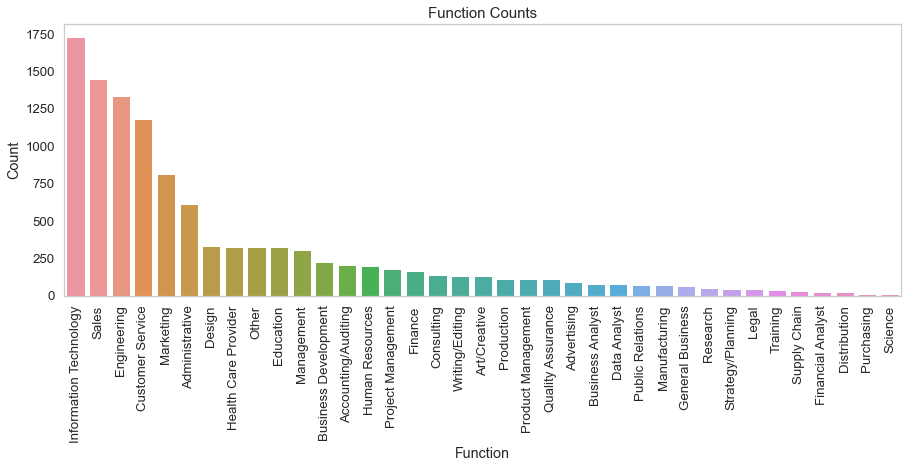

In [148]:
# Plot the categorical variables with low cardinality.
cat_vars = ["telecommuting", "has_company_logo", "has_questions", 
            "employment_type", "required_experience", "required_education",
            "industry", "function"]

sns.set_style("whitegrid", {'axes.grid' : False})
for col in cat_vars:
    plt.figure(figsize=(15,5))
    ax = sns.countplot(x=col, data=dd_raw_df,
                order = dd_raw_df[col].value_counts().index
                )
    ax.set_title(f"{' '.join(col.split('_')).title()} Counts",fontsize=15)
    ax.set_xlabel(' '.join(col.split('_')).title())
    ax.set_ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()

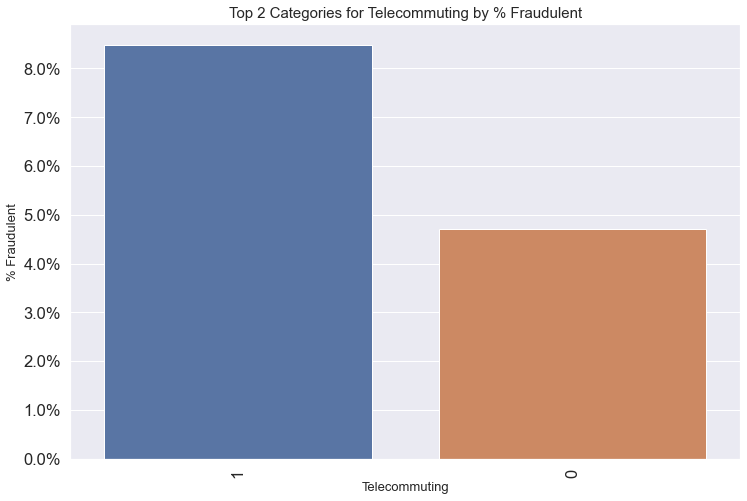

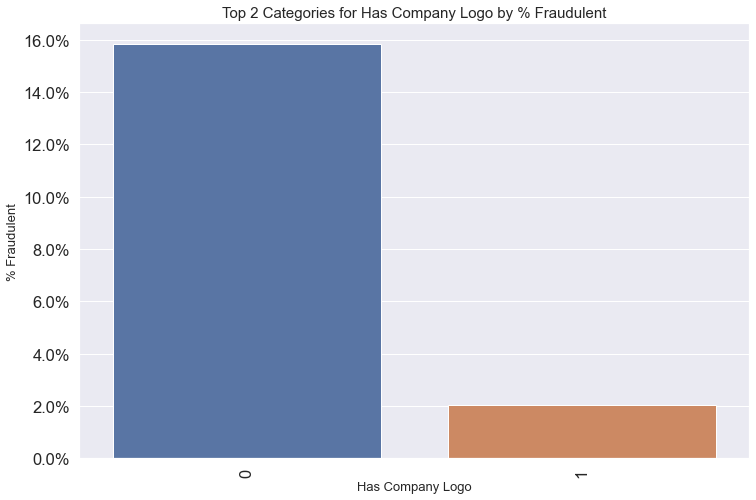

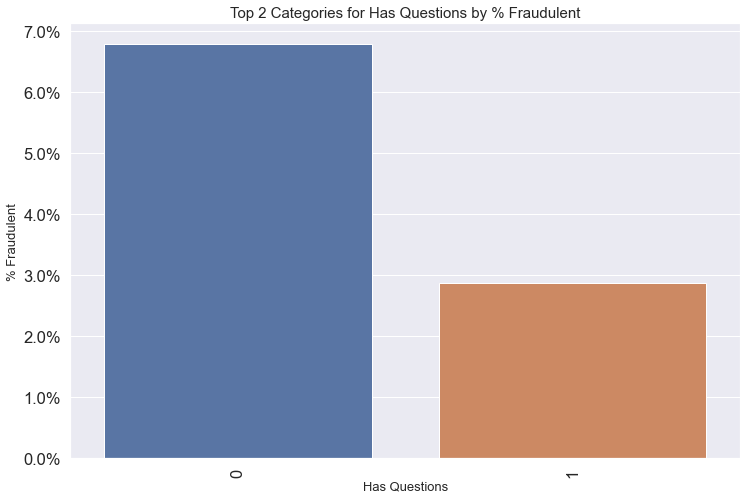

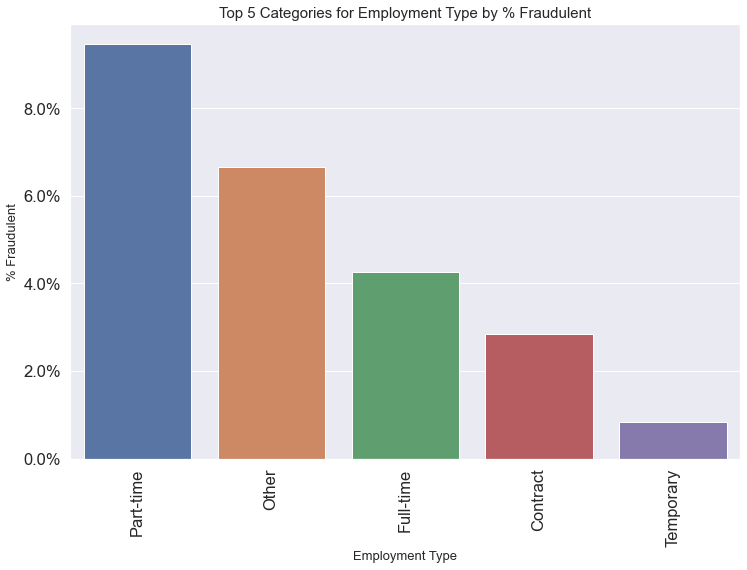

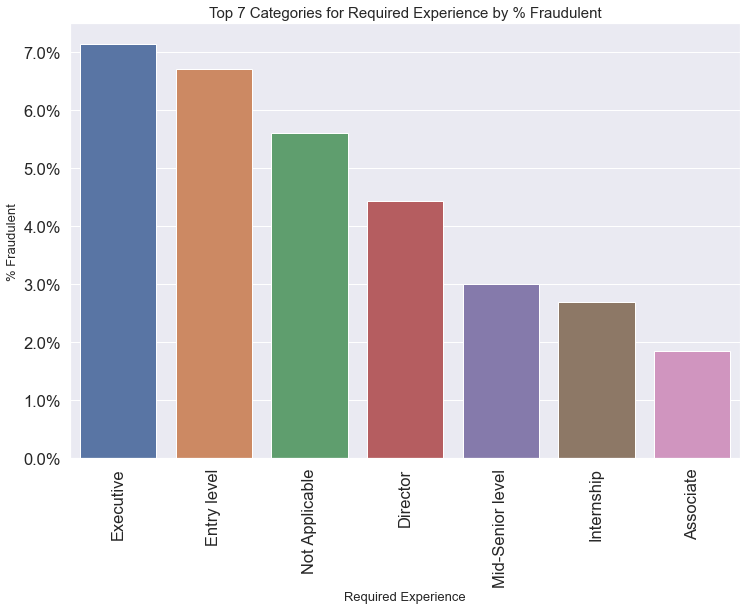

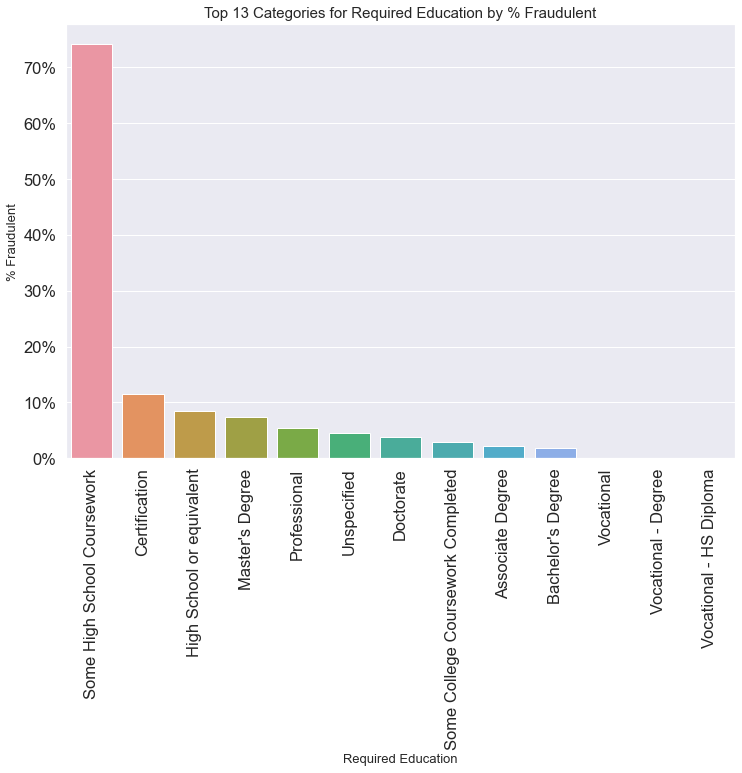

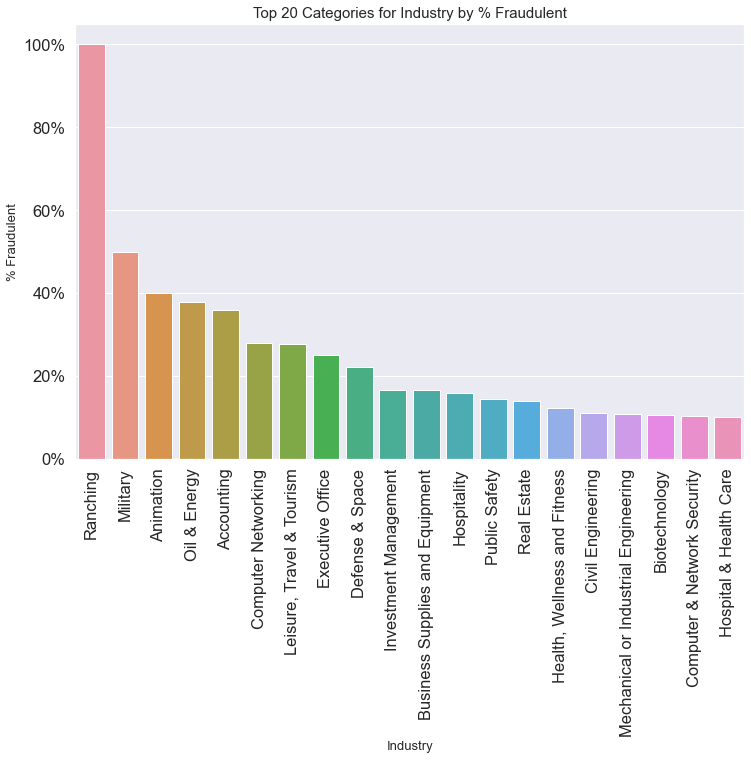

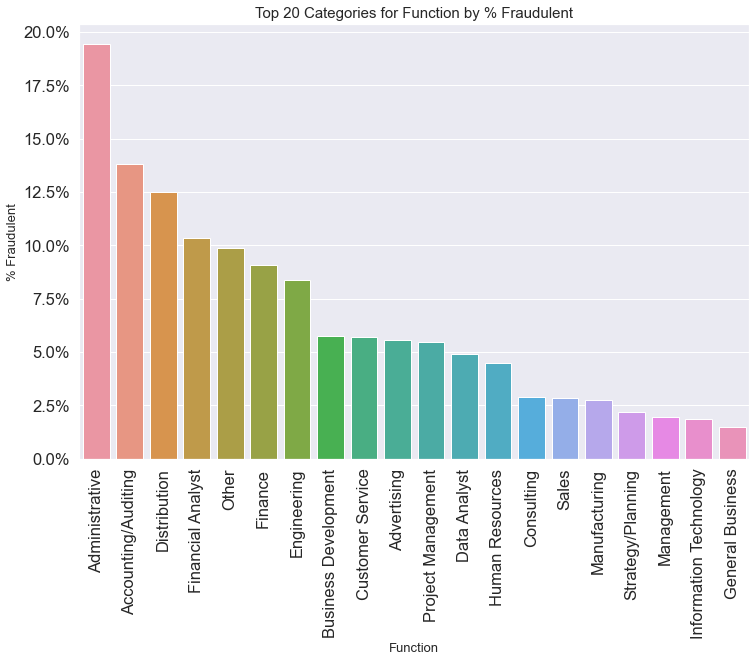

In [155]:
# Plot the categorical variables with up to top 20 by % Fraudulent.
cat_vars = ["telecommuting", "has_company_logo", "has_questions", 
            "employment_type", "required_experience", "required_education",
            "industry", "function"]

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=1.5)

for col in cat_vars:
    df = dd_raw_df.groupby(col).mean('fraudulent')[['fraudulent']].reset_index()
    df['fraudulent'] = df['fraudulent']*100
    df = df.sort_values('fraudulent',ascending = False)[:20]
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df, x = col, y = 'fraudulent', 
                       order = df.sort_values('fraudulent',ascending = False)[[col]].values.flatten())
    
    ax.set_title(f"Top {len(df.index)} Categories for {' '.join(col.split('_')).title()} by % Fraudulent",fontsize=15)
    ax.set_xlabel(' '.join(col.split('_')).title(), fontsize=13)
    ax.set_ylabel("% Fraudulent", fontsize=13)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.xticks(rotation=90)
    plt.show()

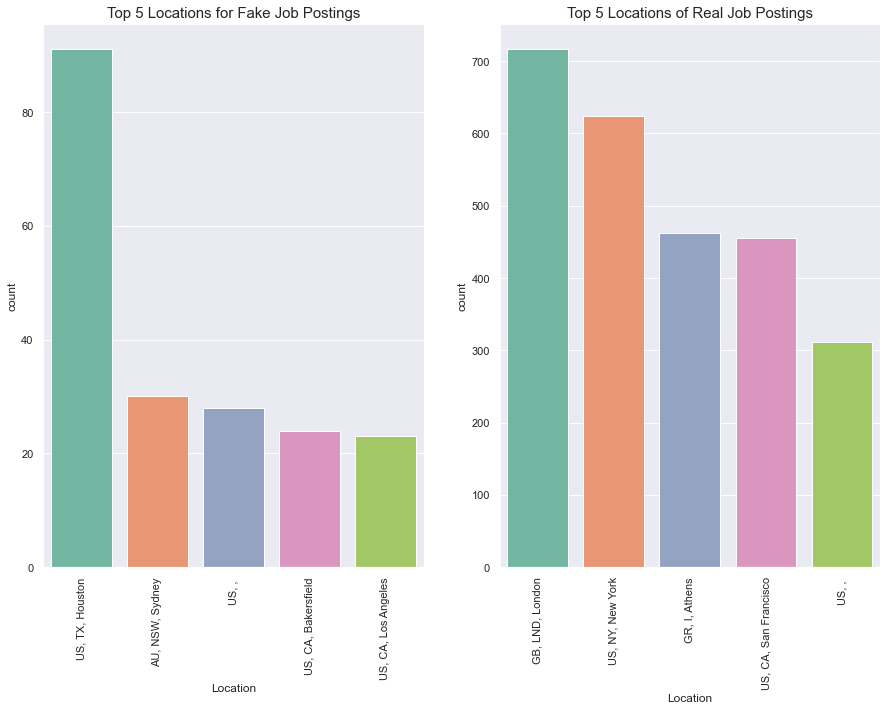

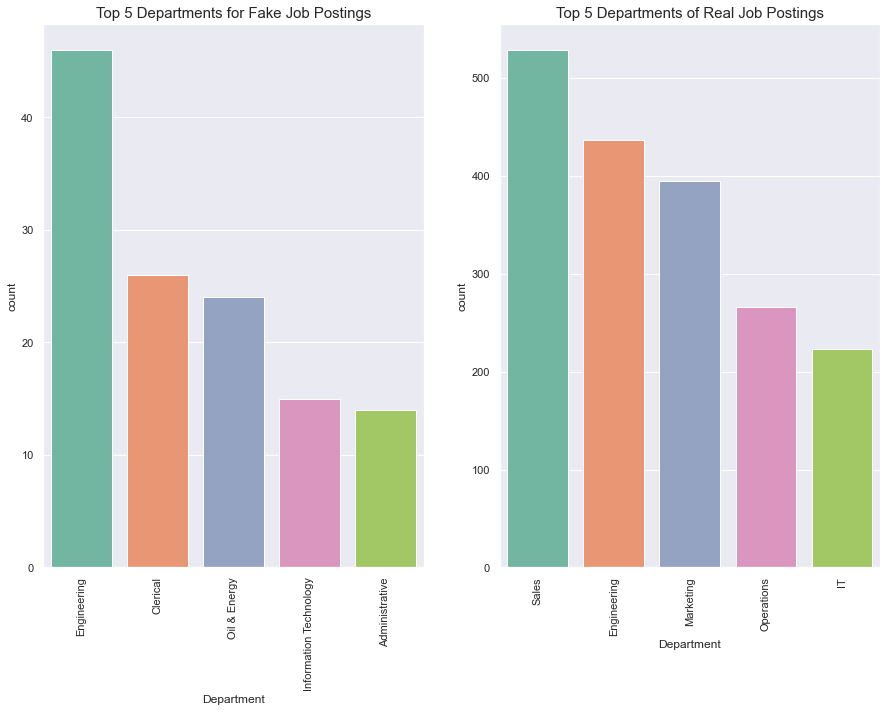

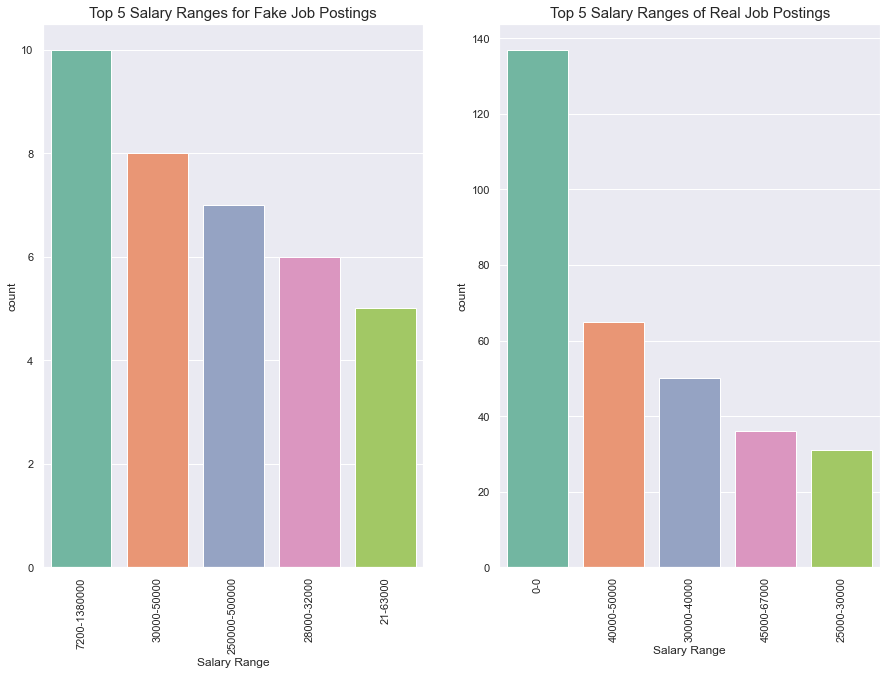

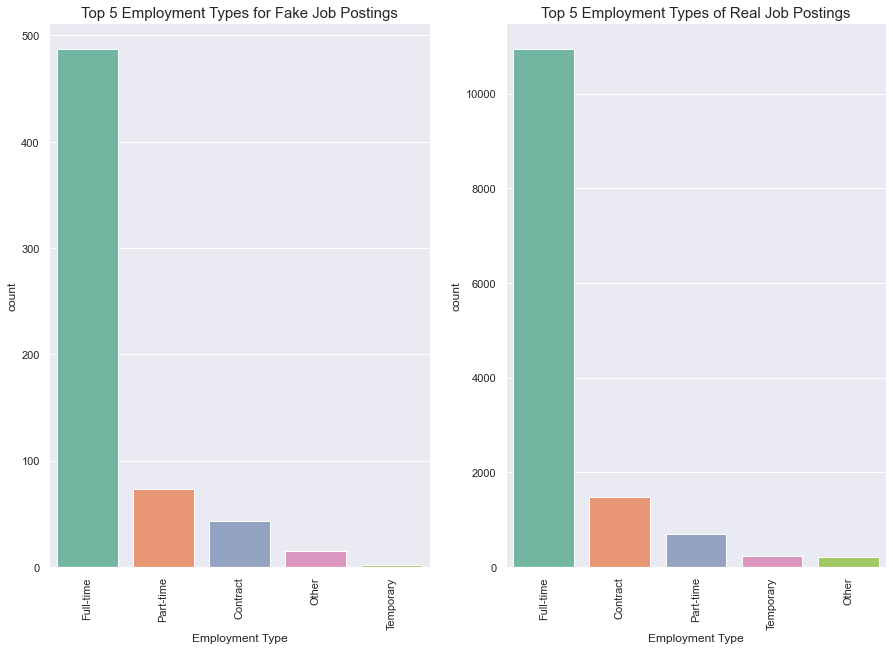

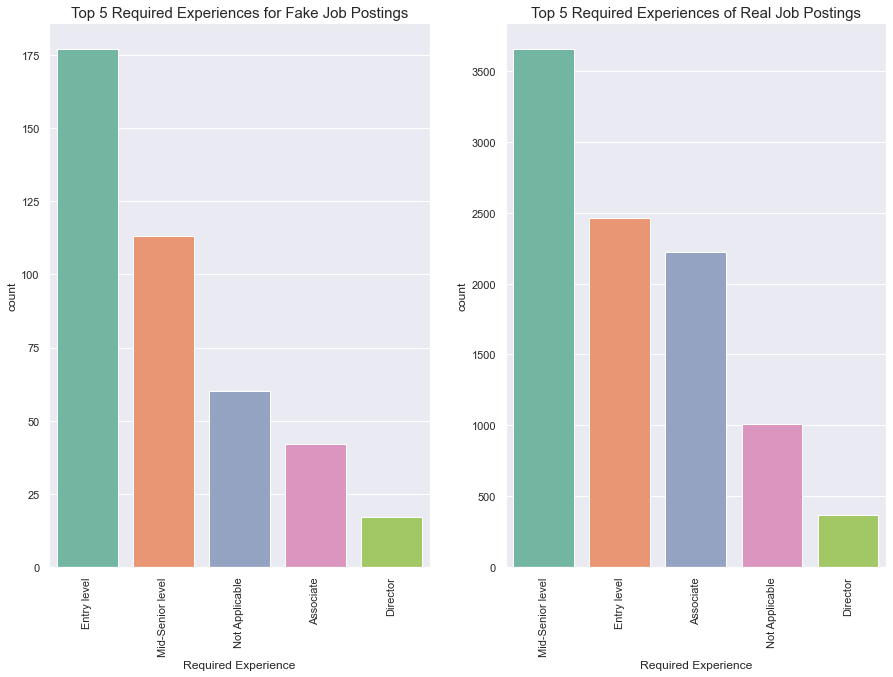

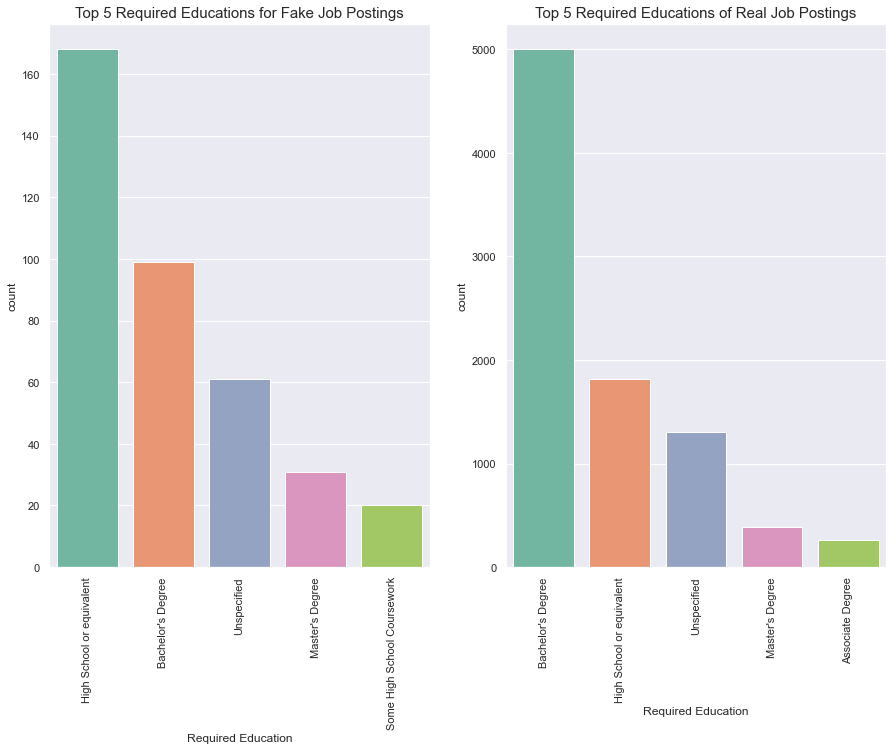

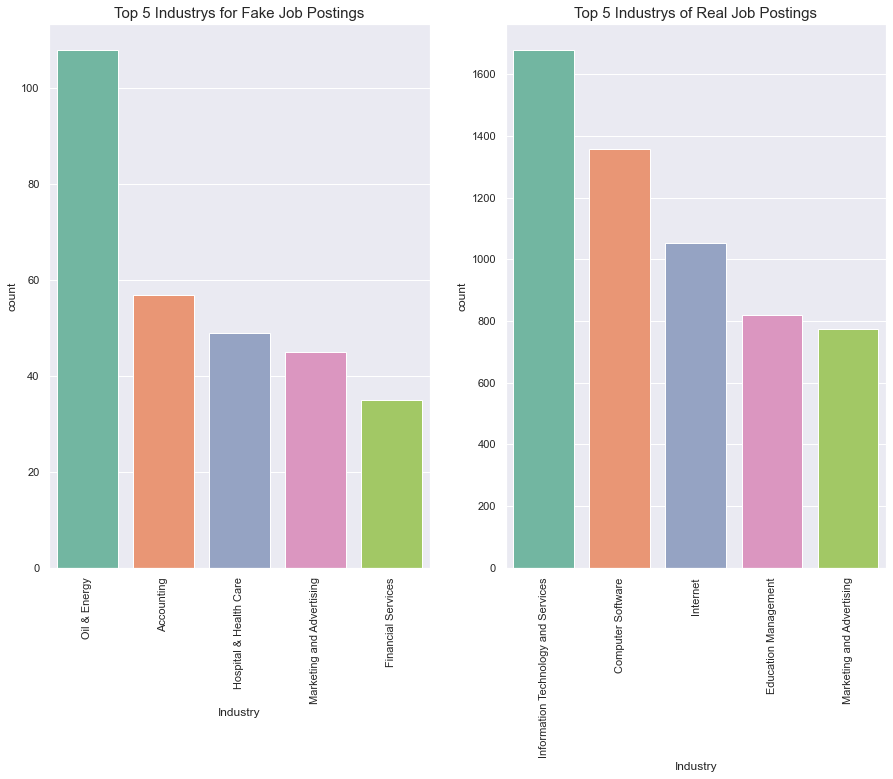

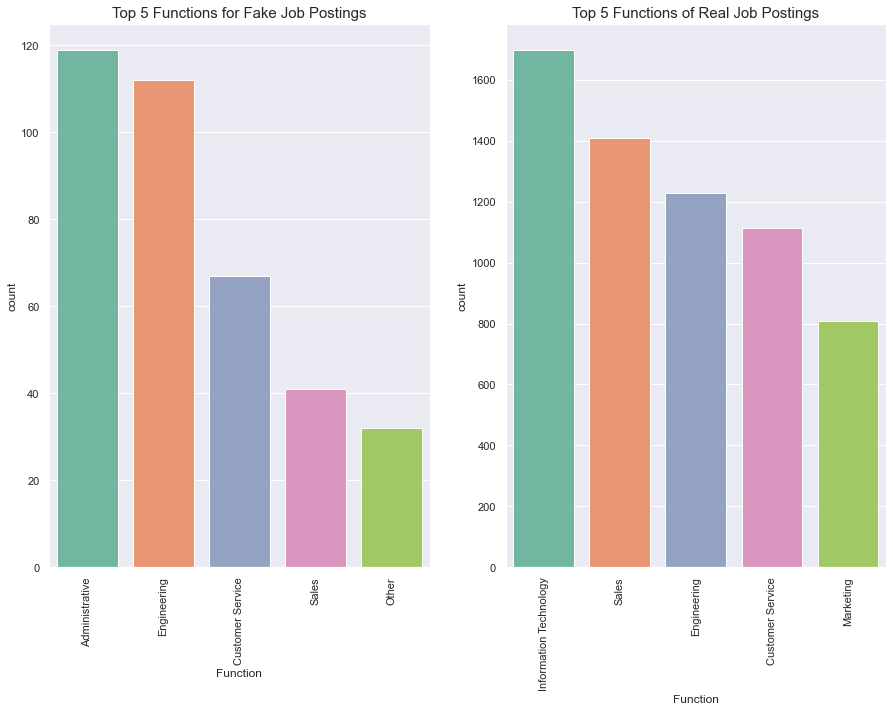

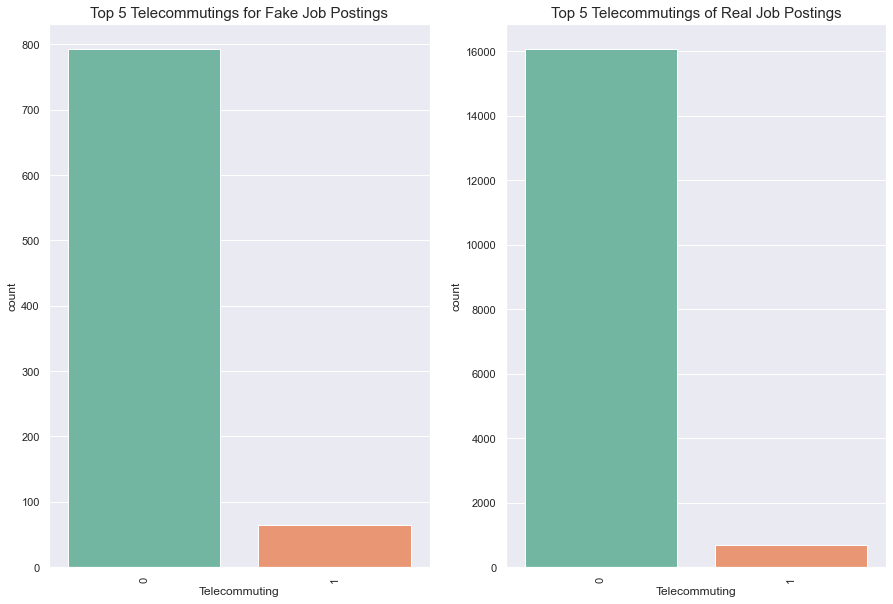

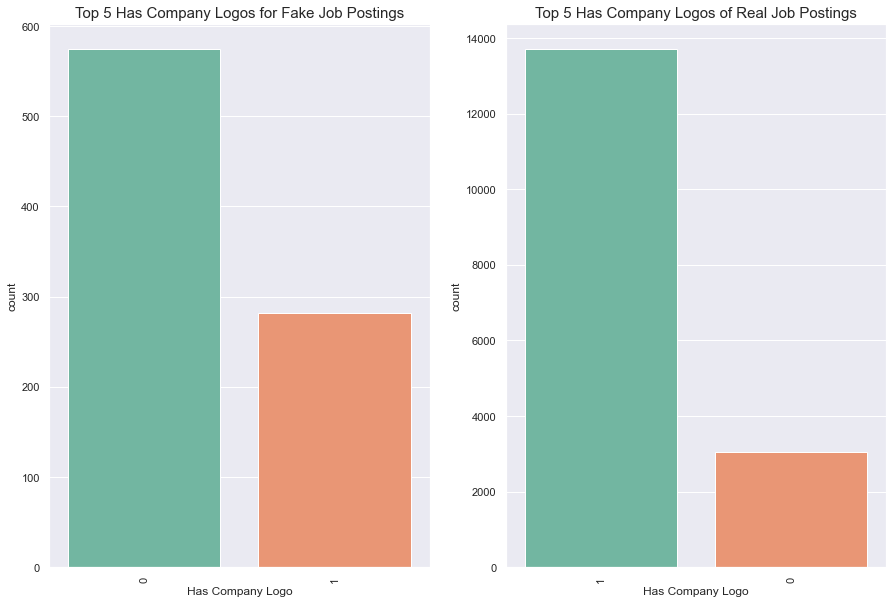

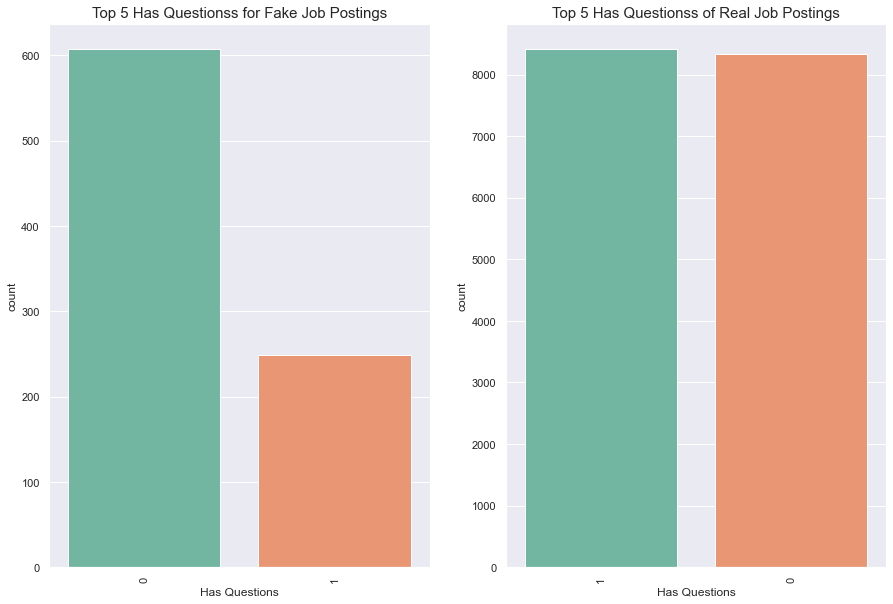

In [108]:
fakejobs = dd_raw_df[dd_raw_df["fraudulent"]==1]
realjobs = dd_raw_df[dd_raw_df["fraudulent"]==0]
colors = sns.color_palette('Set2')[0:10]

cols = ["location","department","salary_range","employment_type",
"required_experience","required_education","industry","function",
"telecommuting","has_company_logo","has_questions"]

sns.set_style('darkgrid')
for n, col in enumerate(cols):
    fig, ax = plt.subplots(1,2,figsize=(15,10))
    sns.countplot(x=col, data=fakejobs,palette='Set2',
                order = fakejobs[col].value_counts()[:5].index,ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    sns.countplot(x=col, data=realjobs,palette='Set2',
                order = realjobs[col].value_counts()[:5].index,ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[0].set_title(f"Top 5 {' '.join(col.split('_')).title()}s for Fake Job Postings",fontsize=15)
    ax[1].set_title(f"Top 5 {' '.join(col.split('_')).title()}s of Real Job Postings",fontsize=15)
    ax[0].set_xlabel(' '.join(col.split('_')).title())
    ax[1].set_xlabel(' '.join(col.split('_')).title())
    plt.show()


We observe for many of our categorical variables that fake posting rates are largely proportional to each other with visible exceptions notable in telecommuting, has_company_logo, has_questions, function, and industry. We calculate the deposit rates for each category.

In [109]:
print(dd_raw_df.fraudulent.value_counts(normalize = True))
print('\n')
for col in cat_vars:
    print('{} split'.format(col))
    print('\n')
    p1 = dd_raw_df[(dd_raw_df.fraudulent == 1)].groupby(col).size().reset_index(name='fraud_counts')
    p2 = dd_raw_df.groupby(col).size().reset_index(name='total_counts')
    p1['total_count'] = p2['total_counts']
    p1['percent_yes'] = p1['fraud_counts']/p2['total_counts']
    print(p1)
    print('\n')

0    0.951361
1    0.048639
Name: fraudulent, dtype: float64


telecommuting split


   telecommuting  fraud_counts  total_count  percent_yes
0              0           792        16845     0.047017
1              1            64          754     0.084881


has_company_logo split


   has_company_logo  fraud_counts  total_count  percent_yes
0                 0           574         3623     0.158432
1                 1           282        13976     0.020177


has_questions split


   has_questions  fraud_counts  total_count  percent_yes
0              0           607         8940     0.067897
1              1           249         8659     0.028756


employment_type split


  employment_type  fraud_counts  total_count  percent_yes
0        Contract            43         1514     0.028402
1       Full-time           487        11423     0.042633
2           Other            15          225     0.066667
3       Part-time            73          772     0.094560
4       Temporary         

### Observations
From these statistics we observe that:

* Postings with telecommuting are about twice as likely to be fraudulent than those without telecommuting.
* Postings without a company logo are about 7 times as likely to be fraudulent than those with a logo.
* Posting where screening questions are not present are 3 times more likely to be fraudulent than those with.
* Part-time and Other employment types tend to have a higher likelihood of being fraudulent than other categories.


# Numeric EDA

In [110]:
# Describe the numerical variables.
dd_raw_df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,17599.000000,17599.000000,17599.000000,17599.000000
mean,0.042843,0.794136,0.492017,0.048639
std,0.202510,0.404343,0.499950,0.215119
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [111]:
# Looking at the skewness of the numerical variables.
dd_raw_df[list(dd_raw_df.select_dtypes(['float64','int64']).columns)].skew()

telecommuting       4.515427
has_company_logo   -1.455049
has_questions       0.031940
fraudulent          4.196869
dtype: float64

In [112]:
# Highlight the maximum in a Series or DataFrame.
def highlight_max(series):
    is_max = series == series.max() #series: true or false
    return ['background-color: green' if t_f else '' for t_f in is_max]

temp_df = dd_raw_df[list(dd_raw_df.select_dtypes(['float64','int64']).columns)]
temp_df.groupby('fraudulent').mean().style.apply(highlight_max)

,telecommuting,has_company_logo,has_questions
fraudulent,,,
0,0.041211,0.817894,0.502299
1,0.074766,0.329439,0.290888


### Observations
From these statistics we observe that:

* telecommuting and fraudulent numerical variables are skewed to the left.
* has_company_logo numerical variable is skewed to the right.
* fraudulent job postings are almost twice as likely to have telecommuting.
* fraudulent job postings are almost half as likely to have a company logo or screening questions present.


# Bivariate EDA
## Correlation Analysis

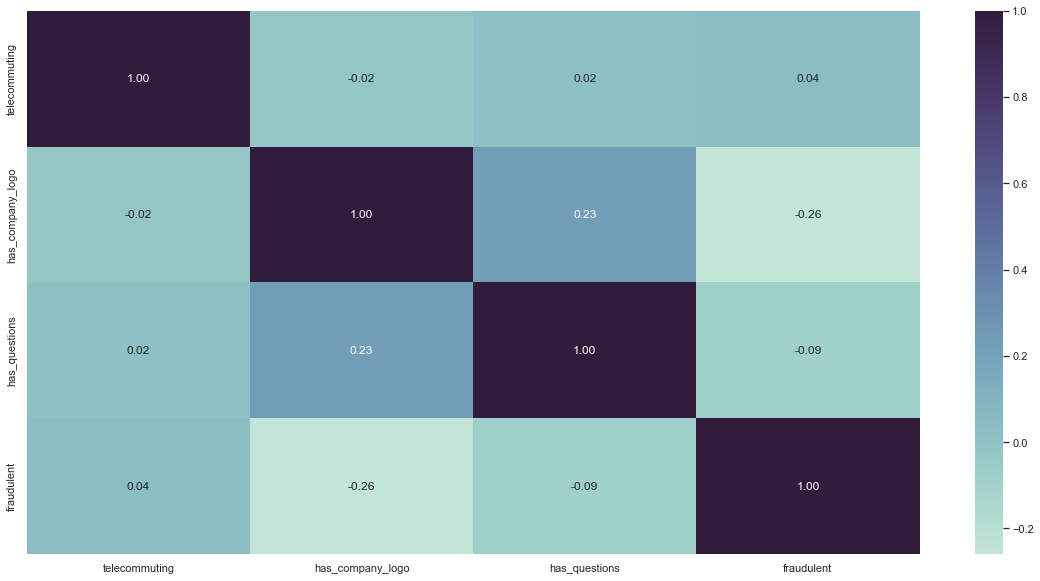

In [113]:
#Correlation Plot
""" 
Pearson r correlation is the most widely used correlation statistic 
to measure the degree of the relationship between linearly related variables. 
""" 
plt.subplots(figsize=(20,10))
cm = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
df = dd_raw_df[list(dd_raw_df.select_dtypes(['float64','int64']).columns)]
sns.heatmap(df.corr(method='pearson'), annot = True, fmt = ".2f", cmap = cm);

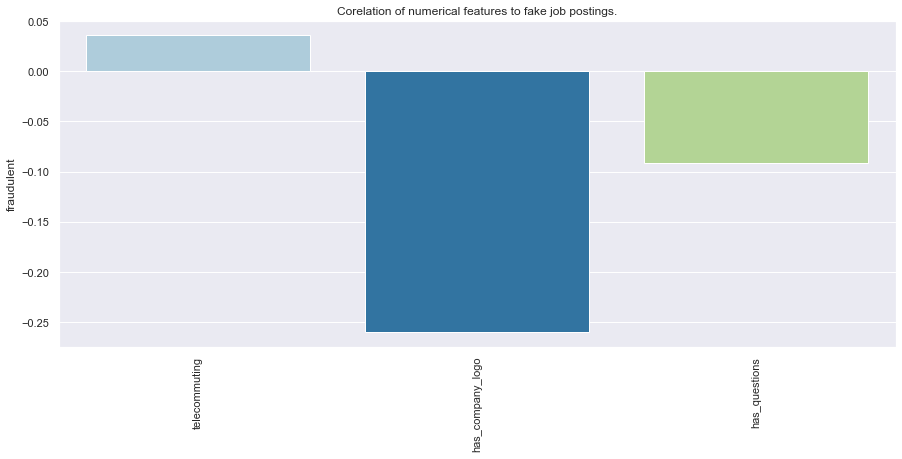

In [114]:
#Correlation with Dependent Comparison
corr = df.corr(method='pearson').fraudulent
plt.figure(figsize = (15,6))
cm = sns.color_palette("Paired")
sns.barplot(x = corr[:-1].index, y = corr[:-1], palette = cm)
plt.title("Corelation of numerical features to fake job postings.")
plt.xticks(rotation=90);

## Pairplots

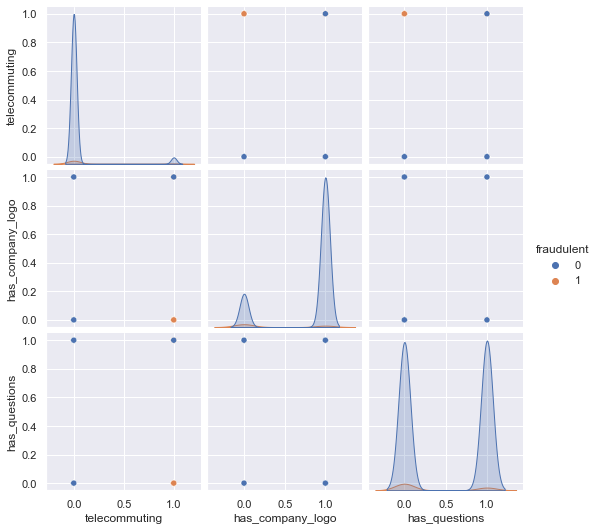

In [115]:
# Pairplot of the data
sns.pairplot(dd_raw_df, hue = 'fraudulent')

### Observations
From these statistics we observe that:

* Correlations accross the numeric variables are low to weak.

## Chi-Square Analysis
Chi-square test of independence of variables in a contingency table.

This function computes the chi-square statistic and p-value for the hypothesis test of independence of the observed frequencies in the contingency table observed. 

In [116]:
# Look for significant relationship between categorical variables and target variable.
categorical_variables_vs_target(data=dd_raw_df,
                                categorical_variables=categorical_variables,
                                target=target)


------------------------------------------
Chi-Square test between title & fraudulent
------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & TITLE
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & TITLE

P-VALUE: 3.5022563223378587e-165
REJECT H0

---------------------------------------------
Chi-Square test between location & fraudulent
---------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & LOCATION
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & LOCATION

P-VALUE: 0.0
REJECT H0

-----------------------------------------------
Chi-Square test between department & fraudulent
-----------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & DEPARTMENT
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & DEPARTMENT

P-VALUE: 6.770599457599411e-220
REJECT H0

-------------------------------------------------
Chi-Square test between salary_range & fraudulent
----------------------------

### Observations
From these statistics we observe that:

* All features reject the null hyposis that there is no relationship.

# Save Deduped Pandas Dataframe

In [117]:
# Save the data set as pickle file

g_drive = "G:/My Drive/ADS-599_Cap_Stone/Capstone_data/"

dd_raw_df.to_pickle(g_drive + "fake_job_postings_dd_raw_df.pkl") 

# Text Data Analysis
Looking at the text based data

In [118]:
# Dataframe of just the text features and target feature (binary)
## title, company_profile, description, requirements, benefits, fraudulent
text_df = dd_raw_df[['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent' ]]

# replace NaN values with ' '
text_df = text_df.fillna(' ')

# checking
text_df.head(5)

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [119]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison

# Stopwords
sw = stopwords.words("english")

In [120]:
# Helper Function - Descriptive Statistics
def descriptive_stats(tokens, top_n_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    if (len(tokens) == 0):
        raise ValueError("Can't work with empty text object.") 
    
    # These are placeholder values. 
    num_tokens = 1
    num_unique_tokens = 0
    avg_token_len = 0.0
    lexical_diversity = 0.0
    
    # Calculate statistics  
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens) # Simple TTR = len(Counter(text))/len(text)
    num_characters = sum([len(i) for i in tokens])
    avg_token_len = np.mean([len(w) for w in tokens]) 

    top_words = Counter(tokens).most_common(top_n_tokens)

    # Inline Printing     
    if verbose:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The average token length in the data is {avg_token_len:.3f}.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"\n\nThe top {top_n_tokens} most common tokens")
        print(top_words)

      
    # Return Dictionary
    results = { 'tokens' : num_tokens, 
            'unique_tokens' : num_unique_tokens,
            'avg_token_length' : avg_token_len,
            'lexical_diversity': lexical_diversity,
            'num_characters': num_characters,
            'top_words': top_words} 

    return(results) 

In [121]:
# Helper Functions - Cleaning data

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

def remove_punctuation(text, punct_set=punctuation) : 
    """This function removes punctuation from a string."""
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def remove_stop(tokens) :
    """This function removes stopwords from a list of tokens."""
    return([t for t in tokens if t.lower() not in sw])
    
def prepare(text, pipeline) : 
    """ This fuction manages and executes other functions like a pipline. """
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [160]:
# Clean and Tokenize Data
df = text_df.copy()

# new column of all the text information combined together, may not be necessary but could address missing values
df['all_text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

# applying the pipeline
my_pipeline = [normalize, remove_punctuation, tokenize, remove_stop]

# we need to apply text cleaning to all of the following:
## 'title', 'company_profile', 'description', 'requirements', 'benefits', 'all_text'
df["title_tokens"] = df["title"].apply(prepare, pipeline=my_pipeline)
df["company_profile_tokens"] = df["company_profile"].apply(prepare, pipeline=my_pipeline)
df["description_tokens"] = df["description"].apply(prepare, pipeline=my_pipeline)
df["requirements_tokens"] = df["requirements"].apply(prepare, pipeline=my_pipeline)
df["benefits_tokens"] = df["benefits"].apply(prepare, pipeline=my_pipeline)
df["all_text_tokens"] = df["all_text"].apply(prepare, pipeline=my_pipeline)

# checking
df.head(5)

,title,company_profile,description,requirements,benefits,fraudulent,all_text,title_tokens,company_profile_tokens,description_tokens,requirements_tokens,benefits_tokens,all_text_tokens
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"Marketing Intern We're Food52, and we've creat...","[marketing, intern]","[food52, weve, created, groundbreaking, awardw...","[food52, fastgrowing, james, beard, awardwinni...","[experience, content, management, systems, maj...",[],"[marketing, intern, food52, weve, created, gro..."
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,Customer Service - Cloud Video Production 90 S...,"[customer, service, cloud, video, production]","[90, seconds, worlds, cloud, video, production...","[organised, focused, vibrant, awesomedo, passi...","[expect, youyour, key, responsibility, communi...","[get, usthrough, part, 90, seconds, team, gain...","[customer, service, cloud, video, production, ..."
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,Commissioning Machinery Assistant (CMA) Valor ...,"[commissioning, machinery, assistant, cma]","[valor, services, provides, workforce, solutio...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",[],"[commissioning, machinery, assistant, cma, val..."
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,Account Executive - Washington DC Our passion ...,"[account, executive, washington, dc]","[passion, improving, quality, life, geography,...","[company, esri, –, environmental, systems, res...","[education, bachelors, masters, gis, business,...","[culture, anything, corporate—we, collaborativ...","[account, executive, washington, dc, passion, ..."
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,Bill Review Manager SpotSource Solutions LLC i...,"[bill, review, manager]","[spotsource, solutions, llc, global, human, ca...","[job, title, itemization, review, managerlocat...","[qualificationsrn, license, state, texasdiplom...","[full, benefits, offered]","[bill, review, manager, spotsource, solutions,..."


In [161]:
# Helper Function - Flatten a List of Lists
def flatten_lists(list_of_lists):
    """This function flattens a list of lists into a single list."""
    return [i for s in list_of_lists for i in s]

In [162]:
# keeping only tokenized columns
df = df.drop(['title','company_profile','description','requirements','benefits', 'all_text'], axis=1)

# checking
df.head(5)

,fraudulent,title_tokens,company_profile_tokens,description_tokens,requirements_tokens,benefits_tokens,all_text_tokens
0,0,"[marketing, intern]","[food52, weve, created, groundbreaking, awardw...","[food52, fastgrowing, james, beard, awardwinni...","[experience, content, management, systems, maj...",[],"[marketing, intern, food52, weve, created, gro..."
1,0,"[customer, service, cloud, video, production]","[90, seconds, worlds, cloud, video, production...","[organised, focused, vibrant, awesomedo, passi...","[expect, youyour, key, responsibility, communi...","[get, usthrough, part, 90, seconds, team, gain...","[customer, service, cloud, video, production, ..."
2,0,"[commissioning, machinery, assistant, cma]","[valor, services, provides, workforce, solutio...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",[],"[commissioning, machinery, assistant, cma, val..."
3,0,"[account, executive, washington, dc]","[passion, improving, quality, life, geography,...","[company, esri, –, environmental, systems, res...","[education, bachelors, masters, gis, business,...","[culture, anything, corporate—we, collaborativ...","[account, executive, washington, dc, passion, ..."
4,0,"[bill, review, manager]","[spotsource, solutions, llc, global, human, ca...","[job, title, itemization, review, managerlocat...","[qualificationsrn, license, state, texasdiplom...","[full, benefits, offered]","[bill, review, manager, spotsource, solutions,..."


Running Descriptive Statistics and Creating WordClouds for the Description, Company Profile, and All Text Columns.

In [163]:
# Helper Function - Plot Word Cloud

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)



def plot_wc(wordcloud_df):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """
    plt.figure(figsize=(8,4))
    wordcloud(wordcloud_df['freq'], max_words=1000, stopwords=sw)


Focusing on Description text:
The five most common tokens are team, work, business, new, and experience.

In [164]:
# Statistics on Description
description_results = descriptive_stats(flatten_lists(
    df['description_tokens']))

There are 1889538 tokens in the data.
There are 103747 unique tokens in the data.
There are 14689513 characters in the data.
The average token length in the data is 7.774.
The lexical diversity is 0.055 in the data.


The top 5 most common tokens
[('team', 17029), ('work', 13716), ('business', 10229), ('new', 9572), ('experience', 9152)]


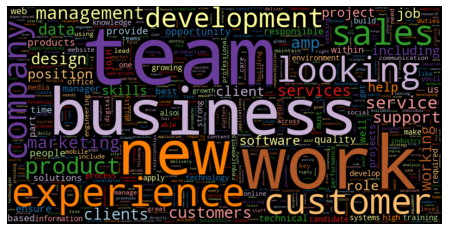

In [165]:
wordcloud_df = count_words(df, column='description_tokens')
plot_wc(wordcloud_df)

Focusing on Company Profile text:
The five most common tokens are team, work, services, company, and people.

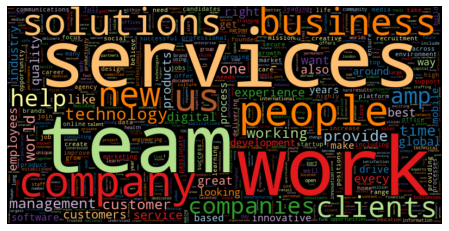

In [166]:
wordcloud_df = count_words(df, column='company_profile_tokens')
plot_wc(wordcloud_df)

Focusing on the created 'all text' information:
The five most common tokens are work, experience, team, business, and company.

In [167]:
# Statistics on the 'all text' column
all_text_results = descriptive_stats(flatten_lists(df['all_text_tokens']))

There are 4218080 tokens in the data.
There are 172071 unique tokens in the data.
There are 32474959 characters in the data.
The average token length in the data is 7.699.
The lexical diversity is 0.041 in the data.


The top 5 most common tokens
[('work', 33988), ('experience', 32628), ('team', 30849), ('business', 20822), ('company', 19239)]


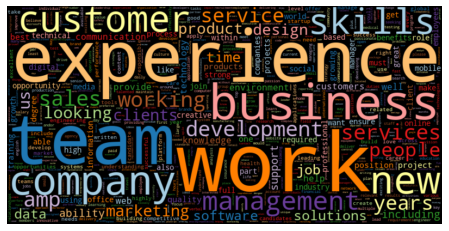

In [168]:
wordcloud_df = count_words(df, column='all_text_tokens')
plot_wc(wordcloud_df)

Looking at how target of fraudulent job posts compares to text data, particularly in the company profile, description, and all text columns.


In [169]:
# First, making columns for lengths of the tokenized company profile, description, and all text
df['description_token_length'] = df['description_tokens'].str.len()
df['company_profile_token_length'] = df['company_profile_tokens'].str.len()
df['all_text_token_length'] = df['all_text_tokens'].str.len()

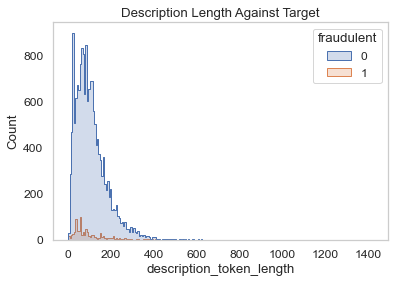

In [175]:
# plotting description length against fraudulent result
sns.set_style("whitegrid", {'axes.grid' : False})
sns.histplot(data= df, x= 'description_token_length', 
             hue='fraudulent', 
             element='step').set(title='Description Length Against Target')
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=1.1)
plt.show()

It appears that fraudulent job posts tend to have shorter descriptions. By shorter, there are fewer than 200 tokens


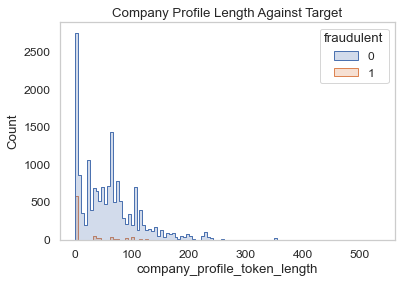

In [180]:
# plotting company_profile length against fraudulent result
sns.set_style("whitegrid", {'axes.grid' : False})
sns.histplot(data= df, x= 'company_profile_token_length', 
             hue='fraudulent', 
             element='step').set(title='Company Profile Length Against Target')
sns.set(font_scale=1.1)
plt.show()

Fake job posts have very short or missing company profiles.

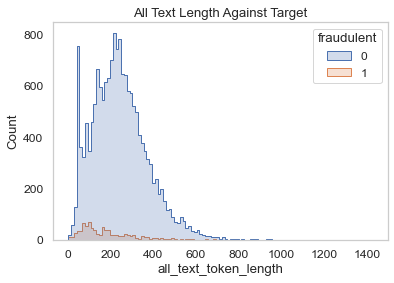

In [181]:
# plotting all_text length against fraudulent result
sns.set_style("whitegrid", {'axes.grid' : False})
sns.histplot(data= df, x= 'all_text_token_length', 
             hue='fraudulent', element='step').set(title='All Text Length Against Target')
sns.set(font_scale=1.1)
plt.show()

Looking at the text variables (title, company_profile, description, requirements, and benefits) all combined, the fake posts still keep things short at around 200 or fewer tokens. 

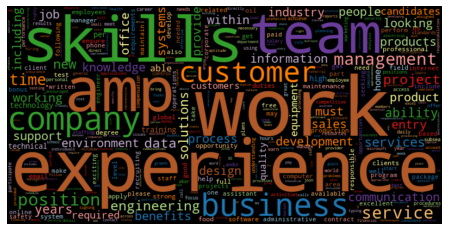

In [135]:
wordcloud_df = count_words(df[df['fraudulent']==1], column='all_text_tokens')
plot_wc(wordcloud_df)

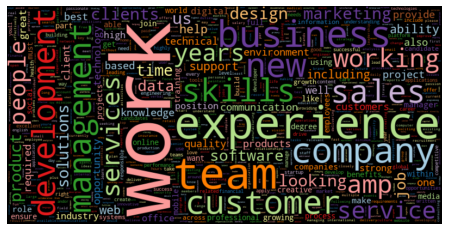

In [136]:
wordcloud_df = count_words(df[df['fraudulent']==0], column='all_text_tokens')
plot_wc(wordcloud_df)

In [137]:
df[df['fraudulent']==1]

,fraudulent,title_tokens,company_profile_tokens,description_tokens,requirements_tokens,benefits_tokens,all_text_tokens,description_token_length,company_profile_token_length,all_text_token_length
98,1,"[ice, technician]","[staffing, amp, recruiting, done, right, oil, ...","[icampe, technician, bakersfield, ca, mt, poso...","[qualificationsknowledge, skills, amp, abiliti...","[benefitswhat, offeredcompetitive, compensatio...","[ice, technician, staffing, amp, recruiting, d...",197,90,449
144,1,"[forward, cap]",[],"[group, raised, fund, purchase, homes, southea...",[],[],"[forward, cap, group, raised, fund, purchase, ...",25,0,27
173,1,"[technician, instrument, controls]","[edison, international, refined, resources, pa...","[technician, instrument, amp, controlslocation...","[job, qualificationsability, understand, proce...","[team, almost, 8000, employees, help, power, a...","[technician, instrument, controls, edison, int...",387,46,555
180,1,"[sales, executive]",[],"[sales, executive]","[sales, executive]","[sales, executive]","[sales, executive, sales, executive, sales, ex...",2,0,8
215,1,"[ice, technician, mt, poso]","[staffing, amp, recruiting, done, right, oil, ...","[icampe, technician, bakersfield, ca, mt, poso...","[qualificationsknowledge, skills, amp, abiliti...","[benefitswhat, offeredcompetitive, compensatio...","[ice, technician, mt, poso, staffing, amp, rec...",197,90,455
...,...,...,...,...,...,...,...,...,...,...
17827,1,"[student, positions, parttime, fulltime]",[],"[student, positions, parttime, fulltimeyou, ho...",[],[],"[student, positions, parttime, fulltime, stude...",36,0,40
17828,1,"[sales, associate]",[],"[learn, earn, executive, level, incomefull, tr...","[•, potential, earn, executive, level, income,...","[global, leadership, development, company, ser...","[sales, associate, learn, earn, executive, lev...",23,0,112
17829,1,"[android, developer]",[],"[infullmobile, sp, z, oo, mobile, software, de...","[•, proven, track, record, android, java, proj...","[attractive, salary, adequate, candidate, skil...","[android, developer, infullmobile, sp, z, oo, ...",39,0,151
17830,1,"[payroll, clerk]",[],"[job, descriptionwe, seeking, full, time, payr...","[job, requirements•, high, school, diploma, eq...","[offer, competitive, salary, benefits, package...","[payroll, clerk, job, descriptionwe, seeking, ...",27,0,71
